<a href="https://colab.research.google.com/github/p-kaushal/Deep-Learning-GroupPorject-TeamJohnson/blob/main/MMAI894_Covid19_Conv_Step2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Read the File**

## Set up

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Apr  3 01:48:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    46W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
#Import Modules 

from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow
import pandas as pd
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Dropout, Layer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

## Mount the google drive and unzip the file

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Move the Covid-19 Zip File from Google Drive into Content Folder
os.chdir("/content/drive/MyDrive/TeamProject")
!cp COVID-19-Dataset.zip /content/sample_data
#Change the directory to content and unzip the file
os.chdir("/content/sample_data")
!unzip COVID-19-Dataset.zip

Archive:  COVID-19-Dataset.zip
replace COVID-19 Dataset/CT/COVID/0104.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Loading the pics and labels into lists

In [3]:
#Read the paths of covid x-ray pictures
imagePaths = os.listdir("/content/sample_data/COVID-19 Dataset/X-ray/COVID")
os.chdir("/content/sample_data/COVID-19 Dataset/X-ray/COVID")

In [4]:
#Put the covid x-ray pictures and labels into lists
data = []
labels = []

for imagePath in imagePaths:    
    label = 1  
    image = cv2.imread(imagePath)     
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
    image = cv2.resize(image, (224, 224))    
    data.append(image)    
    labels.append(label)

In [5]:
#Read the paths of non covid x-ray pictures
imagePaths = os.listdir("/content/sample_data/COVID-19 Dataset/X-ray/Non-COVID")
os.chdir("/content/sample_data/COVID-19 Dataset/X-ray/Non-COVID")

In [6]:
#Put the non-covid x-ray pictures and labels into lists
for imagePath in imagePaths:    
    label = 0  
    image = cv2.imread(imagePath)     
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
    image = cv2.resize(image, (224, 224))    
    data.append(image)    
    labels.append(label)

In [7]:
#Check the number of pictures
print(len(data))
print(len(labels))

9544
9544


In [8]:
#Make the lable list into a ndarry
labels = np.array(labels)

In [9]:
#Make the picture list into a ndarry and normalize
data = np.array(data,dtype=np.float32)/255

In [10]:
#Categorize the label 
labels =keras.utils.to_categorical(labels)

## Train/Test Split

In [11]:
# Split the train and test data
(trainX, testX, trainY, testY) = train_test_split(data,
                                                  labels,
                                                  test_size=0.2,
                                                  # stratify=labels,
                                                  random_state=42,
                                                  shuffle=True
                                                  )

In [12]:
#Check the lenghth of the train/test sets
print("Length of TrainX:" ,len(trainX))
print("Length of TestX:" ,len(testX))
print("Length of TrainY:" ,len(trainY))
print("Length of TestY:" ,len(testY))

Length of TrainX: 7635
Length of TestX: 1909
Length of TrainY: 7635
Length of TestY: 1909


In [13]:
#Check the shape of item in the train sets
print(trainX[0].shape)
print(trainY[0].shape)

(224, 224, 3)
(2,)


# **Data Augmentation**

In [ ]:
# augmentation = keras.preprocessing.image.ImageDataGenerator(rotation_range=15,
#                                                   # width_shift_range=0.2,
#                                                   # height_shift_range=0.2,
#                                                   # shear_range=0.2,
#                                                   # zoom_range=0.2,
#                                                       horizontal_flip=True,
#                                                       fill_mode='nearest')

# **Model Functions Building**

## Base Model Building Function

In [14]:
def build_base_model():
  if model_select_id == "base":
    baseModel=model_select

  else:
    print('No Model')

  for layer in baseModel.layers:
    layer.trainable = False
      
  headModel = baseModel.output
  headModel = tf.keras.layers.Flatten(name="flatten")(headModel)
  headModel = Dense(2, activation="softmax")(headModel)

  model = keras.Model(inputs=baseModel.input, outputs=headModel)

  return model

## Dense Model with Structure 2 Function

In [15]:
def build_dense_model_2(s2_filers,s2_kernal_size):
    
  if model_select_id == "structure2":

    baseModel=model_select

    for layer in baseModel.layers:
      layer.trainable = False

    headModel = baseModel.output
    headModel = tf.keras.layers.Conv2D(filters=s2_filers,activation="relu",kernel_size=s2_kernal_size)(headModel) 
    headModel = tf.keras.layers.MaxPooling2D(pool_size=2)(headModel)
    headModel = tf.keras.layers.Flatten(name="flatten")(headModel)
    headModel = Dense(2, activation="softmax")(headModel)

    model = keras.Model(inputs=baseModel.input, outputs=headModel)

  else:
    print('No Model')

  
  model.compile(optimizer=optimizer,
                loss=loss_function,
                metrics=["accuracy"])

  return model



## Model Compiling Function

In [16]:
def compile_model(model,optimizer,loss_function):
  
  model.compile(optimizer=optimizer, loss=loss_function,metrics=(keras.metrics.Recall(),
                                                                 keras.metrics.Precision(),
                                                                 keras.metrics.CategoricalAccuracy(),
                                                                 keras.metrics.AUC()
                                                                 ))
  return model

## Model Training Function

In [17]:
def train_model(model, X_train, Y_train,num_epochs,batch_size):

  history = model.fit(trainX, trainY, batch_size=batch_size, validation_split = 0.2, epochs=num_epochs)
  
  return model, history

# **Model Execution**

## Hyper-Parameter Set up

In [18]:
optimizer='SGD'
loss_function='CategoricalCrossentropy'
num_epochs=2
batch_size=32

s1_layer1_n = [32,64,128,256]
s1_layer2_n = [32,64,128,256]
s1_dp_rate1 = [0,0.2,0.3]
s1_dp_rate2 = [0,0.2,0.3]

s2_kernal_size = [2]#,3,4]
s2_filers = [16]#,32,64]

s3_layer1_n = [32,64,128,256]
s3_layer2_n = [32,64,128,256]
s3_filers = [16,32,64]



## Model Training

### Base Model DenseNet121

In [19]:
model_select_id = "base"
model_select=keras.applications.DenseNet121(input_shape=(224,224,3),include_top=False,weights='imagenet')

model_trained=build_base_model()
model_trained.summary()
model_trained = compile_model(model_trained,optimizer,loss_function)
model_trained, history = train_model(model_trained, trainX, trainY, num_epochs, batch_size)

model_trained.evaluate(testX,testY,return_dict=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

{'auc': 0.8739987015724182,
 'categorical_accuracy': 0.8627553582191467,
 'loss': 5.783263206481934,
 'precision': 0.8627553582191467,
 'recall': 0.8627553582191467}

In [20]:
pred_Y = model_trained.predict(testX)

print('classification report:')
print('\n')
print(classification_report(testY.argmax(axis=1),pred_Y.argmax(axis=1)))

classification report:


              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1088
           1       0.95      0.72      0.82       821

    accuracy                           0.86      1909
   macro avg       0.88      0.85      0.85      1909
weighted avg       0.88      0.86      0.86      1909



### DenseNet121 with a Head Model of Structure2

In [22]:
#Use GridSearch to find the best hyper parameters
model_select_id = "structure2"
model_select=keras.applications.DenseNet121(input_shape=(224,224,3),include_top=False,weights='imagenet')


model_CV = KerasClassifier(build_fn=build_dense_model_2, epochs=2, batch_size=32, verbose=1)

param_grid = dict(s2_kernal_size=s2_kernal_size,
                  s2_filers=s2_filers)


grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, cv=5)

grid_result = grid.fit(trainX, trainY)

Epoch 1/2
191/191 [==============================] - 13s 39ms/step - loss: 0.5357 - accuracy: 0.7659
Epoch 2/2
48/48 [==============================] - 3s 38ms/step - loss: 0.2310 - accuracy: 0.9129
Epoch 1/2
191/191 [==============================] - 14s 41ms/step - loss: 0.5641 - accuracy: 0.7619
Epoch 2/2
48/48 [==============================] - 4s 40ms/step - loss: 0.2816 - accuracy: 0.8815
Epoch 1/2
191/191 [==============================] - 13s 39ms/step - loss: 0.6084 - accuracy: 0.7543
Epoch 2/2
48/48 [==============================] - 4s 38ms/step - loss: 0.3013 - accuracy: 0.8788
Epoch 1/2
191/191 [==============================] - 13s 39ms/step - loss: 0.6090 - accuracy: 0.7753
Epoch 2/2
48/48 [==============================] - 3s 38ms/step - loss: 0.2401 - accuracy: 0.9031
Epoch 1/2
191/191 [==============================] - 13s 39ms/step - loss: 0.5442 - accuracy: 0.7558
Epoch 2/2
48/48 [==============================] - 4s 38ms/step - loss: 0.2464 - accuracy: 0.9096
Epoch

In [24]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.897184 using {'s2_filers': 16, 's2_kernal_size': 2}


In [25]:
model_select_id = "structure2"
model_select=keras.applications.DenseNet121(input_shape=(224,224,3),include_top=False,weights='imagenet')

model_trained=build_dense_model_2(s2_kernal_size=2,
                                  s2_filers=64)


model_trained.summary()
model_trained = compile_model(model_trained,optimizer,loss_function)
model_trained, history = train_model(model_trained, trainX, trainY, num_epochs, batch_size)

model_trained.evaluate(testX,testY,return_dict=True)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

{'auc_1': 0.9694973826408386,
 'categorical_accuracy': 0.9109481573104858,
 'loss': 0.2266712784767151,
 'precision_1': 0.9109481573104858,
 'recall_1': 0.9109481573104858}

In [26]:
pred_Y = model_trained.predict(testX)

print('classification report:')
print('\n')
print(classification_report(testY.argmax(axis=1),pred_Y.argmax(axis=1)))

classification report:


              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1088
           1       0.92      0.87      0.89       821

    accuracy                           0.91      1909
   macro avg       0.91      0.91      0.91      1909
weighted avg       0.91      0.91      0.91      1909



# **Model Evaluation**

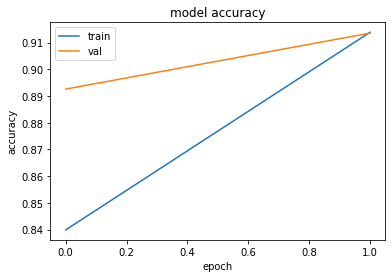

In [29]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

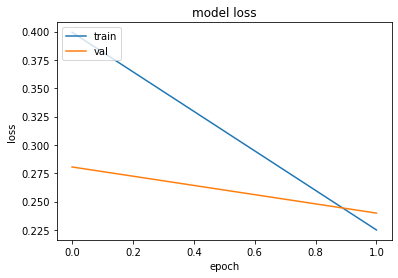

In [30]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **HeatMap**

In [33]:
model_trained.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

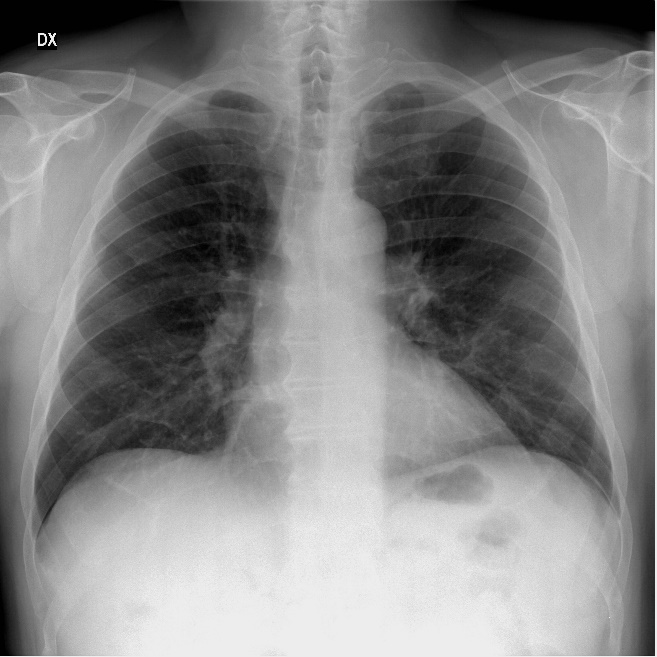

In [66]:
# model_builder = keras.applications.densenet
img_size = (224, 224)
preprocess_input = tf.keras.applications.densenet.preprocess_input
decode_predictions = tf.keras.applications.densenet.decode_predictions

last_conv_layer_name = "conv2d_6"

# The local path to our target image
img_path = '/content/sample_data/COVID-19 Dataset/X-ray/COVID/0107.jpeg'

display(Image(img_path))

In [57]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
  
    array = np.expand_dims(array, axis=0)
    return array

In [61]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1,2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


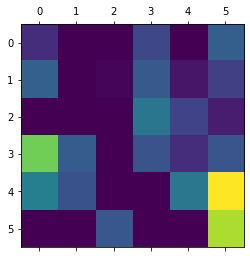

In [62]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
# model = model_builder(weights="imagenet")

# Remove last layer's softmax
model_trained.layers[-1].activation = None

# Print what the top predicted class is
preds = model_trained.predict(img_array)
# print("Predicted:", decode_predictions(preds)[0])

# # Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model_trained, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

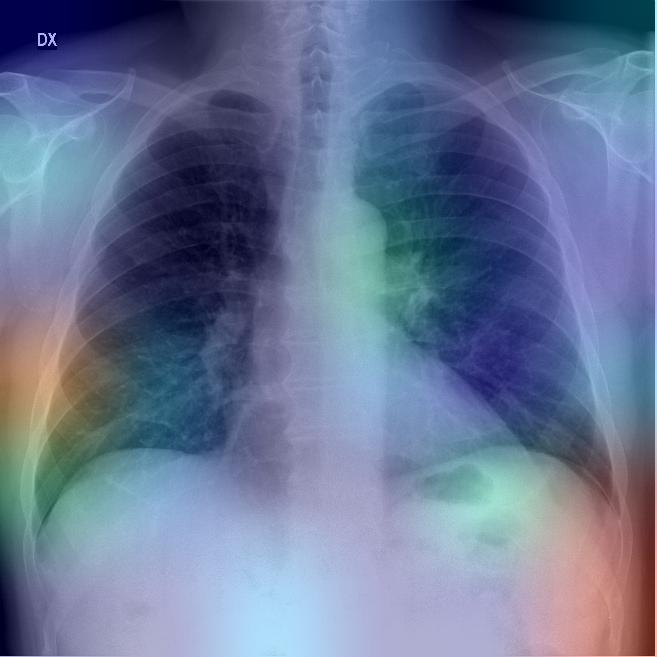

In [65]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)